# Parameter estimation on GW170817 temp

### Instalization

In [1]:
import bilby # Importing the bilby module for gravitational wave analysis
from gwpy.timeseries import TimeSeries # Importing the TimeSeries class from gwpy.timeseries module

logger = bilby.core.utils.logger # Initializing the logger for logging purposes
outdir = 'outdir'  # Setting the output directory path to 'outdir'
label = 'GW170817' # Setting the label for the analysis as 'GW150914'

### Data Setup

In [2]:
trigger_time = 1187008882 # The trigger time for the analysis

roll_off = 0.2  # Roll off duration of tukey window in seconds, default is 0.4s
duration = 32  # Analysis segment duration (Duration of the analysis segment in seconds)
post_trigger_duration = 2  # Time between trigger time and end of segment
end_time = trigger_time + post_trigger_duration # Calculating the end time of the segment
start_time = end_time - duration # Calculating the start time of the segment

psd_duration = 1024   # Duration of the power spectral density estimation
psd_start_time = start_time - psd_duration  # Calculating the start time of the PSD estimation
psd_end_time = start_time # The end time of the PSD estimation is the same as the start time of the segment

### Download the data

In [ ]:
# We now use gwpy to obtain analysis and psd data and create the ifo_list
ifo_list = bilby.gw.detector.InterferometerList([])

# Loop over each detector (H1 and L1)
for det in ["H1", "L1", "V1"]:
    logger.info("Downloading analysis data for ifo {}".format(det))

    # Create an empty interferometer object for the detector
    ifo = bilby.gw.detector.get_empty_interferometer(det)

    # Fetch the strain data from gwpy for the specified time interval
    data = TimeSeries.fetch_open_data(det, start_time, end_time)

    # Set the strain data of the interferometer from the gwpy TimeSeries object
    ifo.strain_data.set_from_gwpy_timeseries(data)

    logger.info("Downloading psd data for ifo {}".format(det))

    # Fetch the PSD data from gwpy for the specified time interval
    psd_data = TimeSeries.fetch_open_data(det, psd_start_time, psd_end_time)

    # Calculate the alpha parameter for the Tukey window
    psd_alpha = 2 * roll_off / duration

    # Calculate the PSD using gwpy's psd() method
    psd = psd_data.psd(
        fftlength=duration,
        overlap=0,
        window=("tukey", psd_alpha),
        method="median"
    )

    # Create a PowerSpectralDensity object using the frequency and PSD arrays
    ifo.power_spectral_density = bilby.gw.detector.PowerSpectralDensity(
        frequency_array=psd.frequencies.value, psd_array=psd.value)

    # Append the interferometer object to the ifo_list
    ifo_list.append(ifo)

logger.info("Saving data plots to {}".format(outdir))

# Check if the output directory exists, if not, create it
bilby.core.utils.check_directory_exists_and_if_not_mkdir(outdir)

# Plot the data using the interferometer list and save the plots to the output directory
ifo_list.plot_data(outdir=outdir, label=label)


14:22 bilby INFO    : Downloading analysis data for ifo H1


### Create a prior

In [4]:
# We now define the prior.
# We have defined our prior distribution in a local file, GW150914.prior
# The prior is printed to the terminal at run-time.
# You can overwrite this using the syntax below in the file,
# or choose a fixed value by just providing a float value as the prior.
priors = bilby.gw.prior.BBHPriorDict(filename='GW170817.prior')

### Create a waveform generator

In [6]:
# In this step we define a `waveform_generator`. This is the object which
# creates the frequency-domain strain. In this instance, we are using the
# `lal_binary_black_hole model` source model. We also pass other parameters:
# the waveform approximant and reference frequency and a parameter conversion
# which allows us to sample in chirp mass and ratio rather than component mass
waveform_generator = bilby.gw.WaveformGenerator(
    frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
    parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
    waveform_arguments={'waveform_approximant': 'IMRPhenomPv2',
                        'reference_frequency': 50})

11:49 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


### Create a likelihood

In [7]:
# In this step, we define the likelihood. Here we use the standard likelihood
# function, passing it the data and the waveform generator.
likelihood = bilby.gw.likelihood.GravitationalWaveTransient(
    ifo_list, waveform_generator, priors=priors, time_marginalization=True,
    phase_marginalization=True, distance_marginalization=True)

11:49 bilby WARNING : Prior not provided for geocent_time, using the BBH default.
11:49 bilby INFO    : Distance marginalisation file .distance_marginalization_lookup.npz does not exist
11:49 bilby INFO    : Building lookup table for distance marginalisation.


  0%|          | 0/400 [00:00<?, ?it/s]

11:55 bilby INFO    : Running for label 'GW150914', output will be saved to 'outdir'
11:55 bilby INFO    : Using lal version 7.2.4
11:55 bilby INFO    : Using lal git version Branch: None;Tag: lalsuite-v7.11;Id: 7a2f2aa176ad39eeaede38f6df4a41d6bf226e8f;;Builder: Unknown User <>;Repository status: CLEAN: All modifications committed
11:55 bilby INFO    : Using lalsimulation version 4.0.2
11:55 bilby INFO    : Using lalsimulation git version Branch: None;Tag: lalsuite-v7.11;Id: 7a2f2aa176ad39eeaede38f6df4a41d6bf226e8f;;Builder: Unknown User <>;Repository status: CLEAN: All modifications committed
11:55 bilby INFO    : Analysis priors:
11:55 bilby INFO    : mass_ratio=bilby.gw.prior.UniformInComponentsMassRatio(minimum=0.125, maximum=1, name='mass_ratio', latex_label='$q$', unit=None, boundary=None, equal_mass=False)
11:55 bilby INFO    : chirp_mass=bilby.gw.prior.UniformInComponentsChirpMass(minimum=25, maximum=35, name='chirp_mass', latex_label='$\\mathcal{M}$', unit=None, boundary=None)

1it [00:00, ?it/s]

12:05 bilby INFO    : Written checkpoint file outdir/GW150914_resume.pickle
12:16 bilby INFO    : Written checkpoint file outdir/GW150914_resume.pickle
12:26 bilby INFO    : Written checkpoint file outdir/GW150914_resume.pickle
12:36 bilby INFO    : Written checkpoint file outdir/GW150914_resume.pickle
12:47 bilby INFO    : Written checkpoint file outdir/GW150914_resume.pickle
12:58 bilby INFO    : Written checkpoint file outdir/GW150914_resume.pickle
13:09 bilby INFO    : Written checkpoint file outdir/GW150914_resume.pickle
13:20 bilby INFO    : Written checkpoint file outdir/GW150914_resume.pickle
13:34 bilby INFO    : Written checkpoint file outdir/GW150914_resume.pickle
13:47 bilby INFO    : Written checkpoint file outdir/GW150914_resume.pickle
14:15 bilby INFO    : Written checkpoint file outdir/GW150914_resume.pickle
14:28 bilby INFO    : Written checkpoint file outdir/GW150914_resume.pickle
14:39 bilby INFO    : Written checkpoint file outdir/GW150914_resume.pickle
14:50 bilby 

16:52 bilby INFO    : Computing per-detector log likelihoods.


  0%|          | 0/530 [00:00<?, ?it/s]

16:53 bilby INFO    : Reconstructing marginalised parameters.


  0%|          | 0/530 [00:00<?, ?it/s]

16:53 bilby INFO    : Generating sky frame parameters.


  0%|          | 0/530 [00:00<?, ?it/s]

16:53 bilby INFO    : Computing SNRs for every sample.


  0%|          | 0/530 [00:00<?, ?it/s]

16:53 bilby INFO    : Summary of results:
nsamples: 530
ln_noise_evidence: -20676.586
ln_evidence: -20396.880 +/-  0.382
ln_bayes_factor: 279.706 +/-  0.382



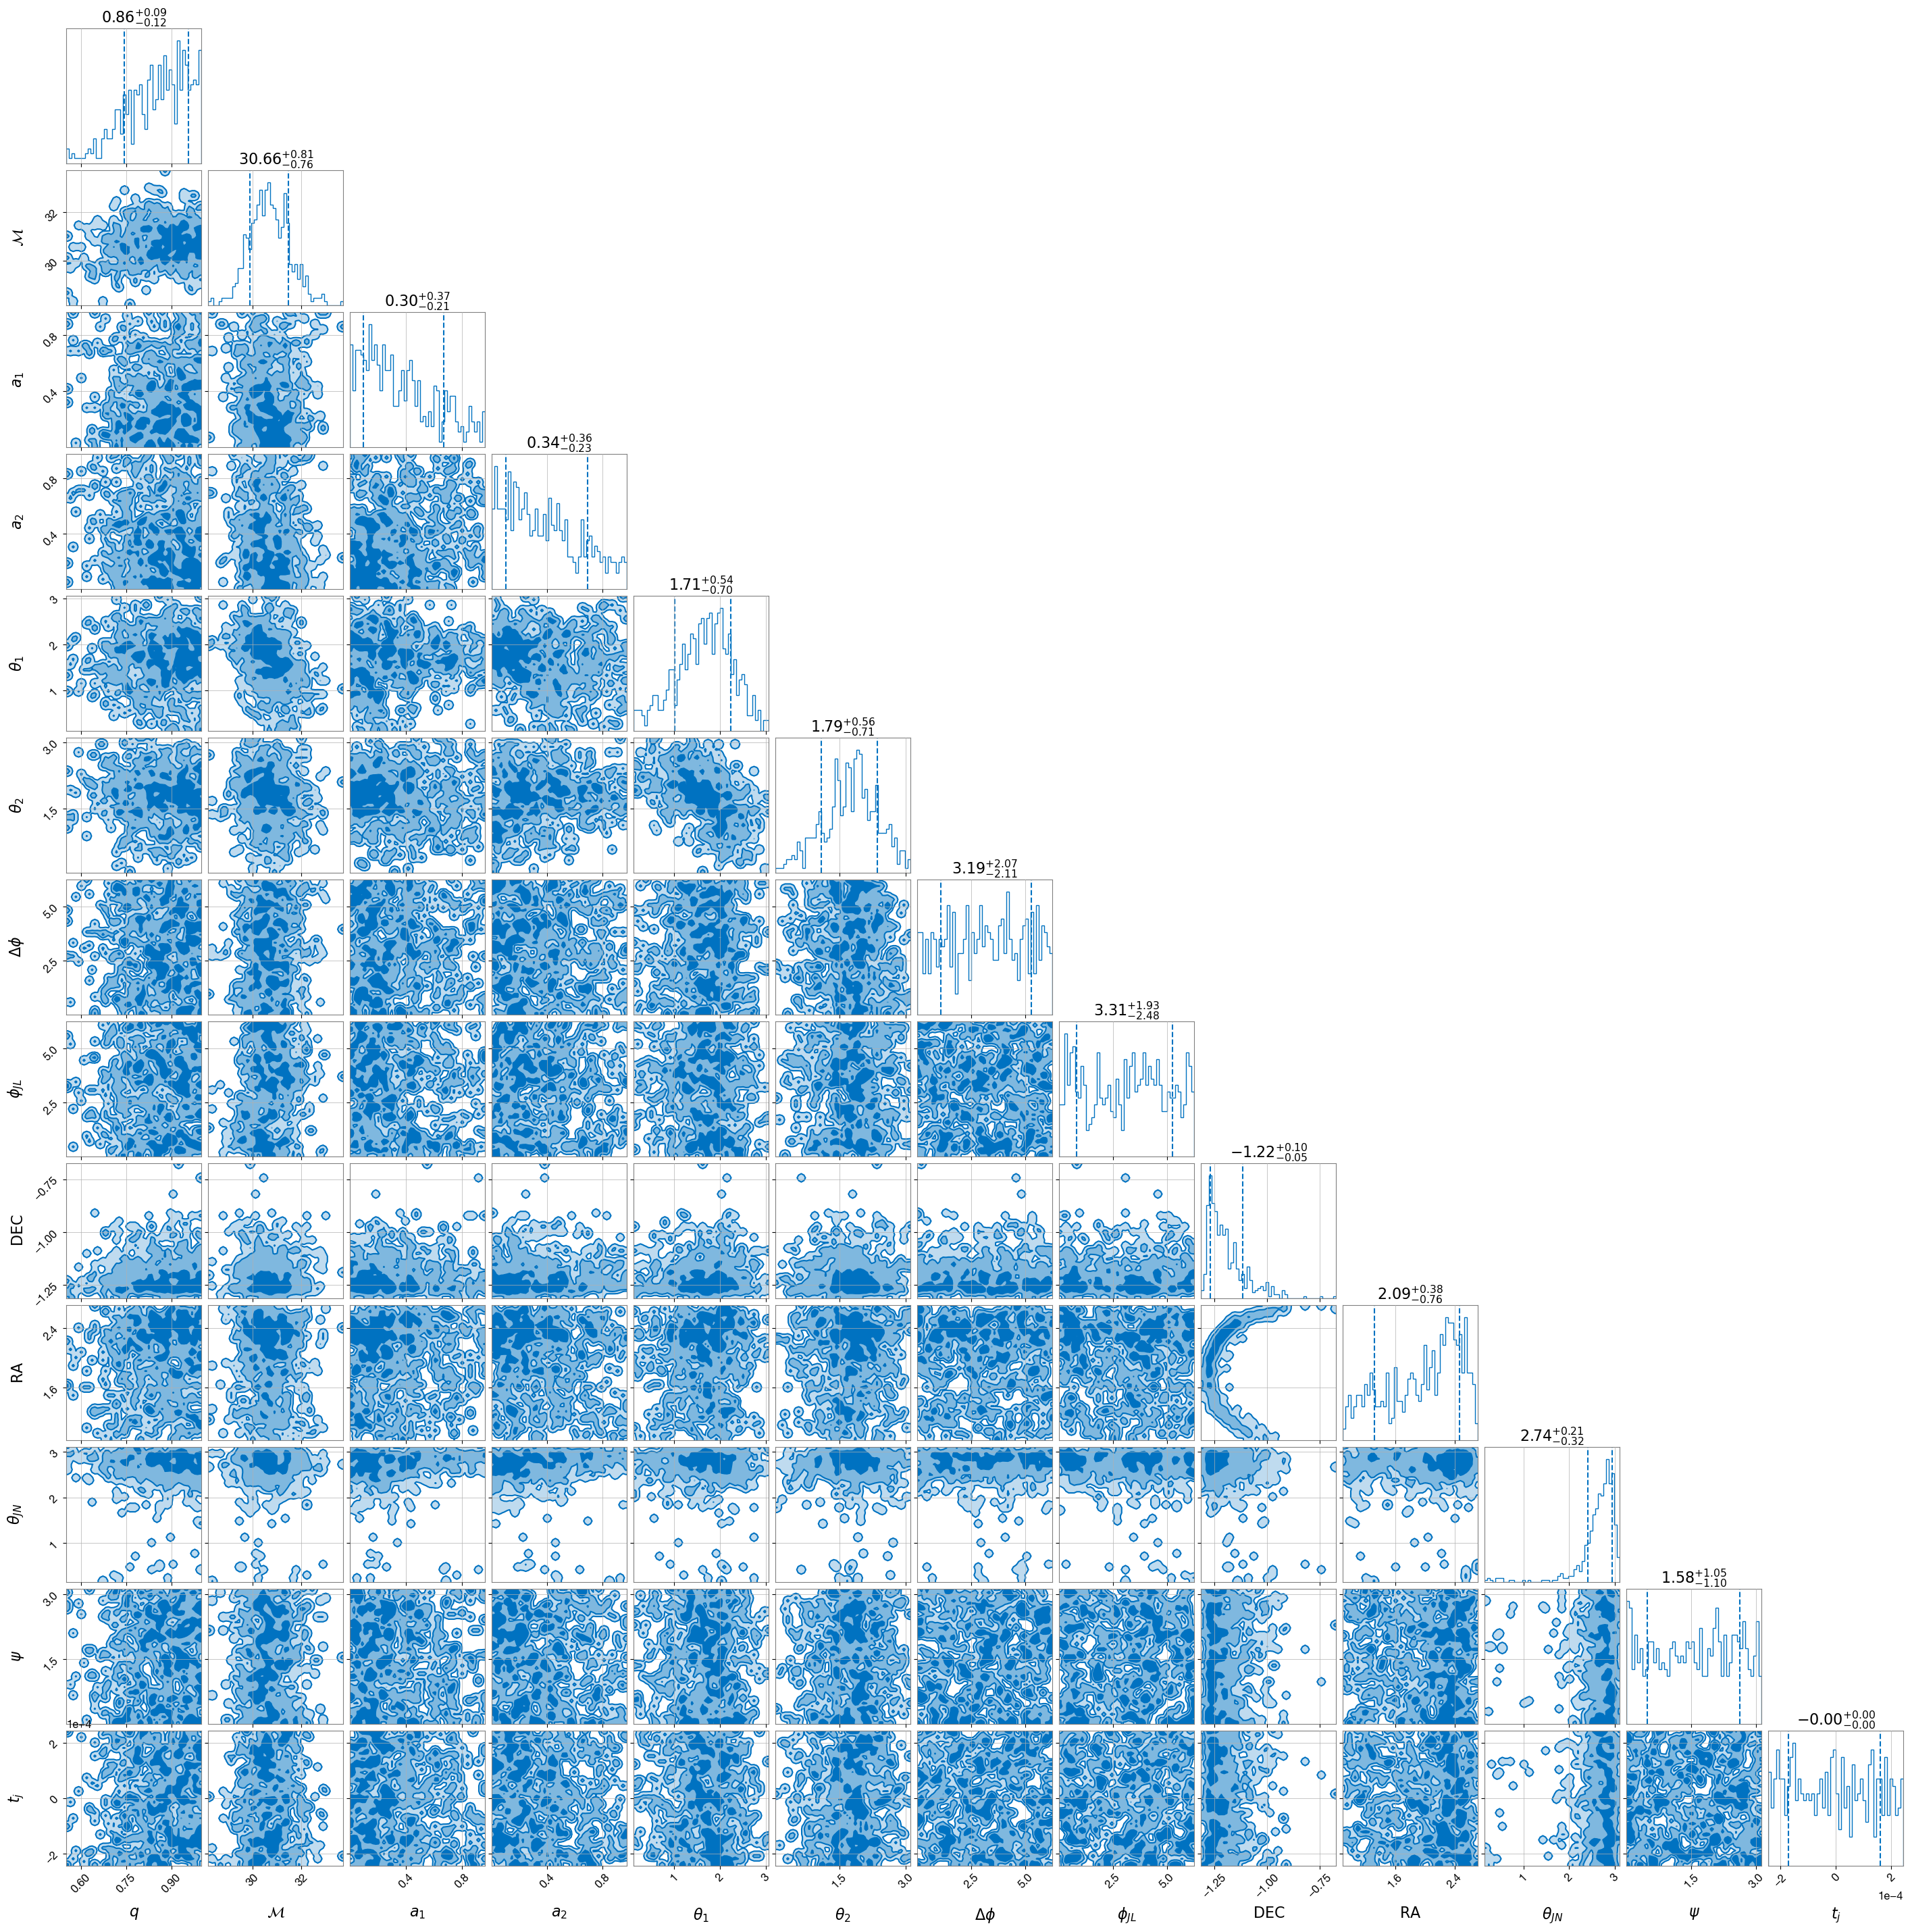

In [9]:
# Finally, we run the sampler. This function takes the likelihood and prior
# along with some options for how to do the sampling and how to save the data
result = bilby.run_sampler(
    likelihood, priors, sampler='dynesty', outdir=outdir, label=label,
    nlive=256, walks=50, n_check_point=5000, check_point_plot=True,dlogz=0.5,
    conversion_function=bilby.gw.conversion.generate_all_bbh_parameters)
result.plot_corner()
#256,50,5000,dlogz=0.5

In [11]:
samples = result.posterior

In [12]:
samples

mass_ratio  chirp_mass       a_1       a_2    tilt_1    tilt_2    phi_12   
0      0.836028   31.725626  0.662000  0.645164  1.615677  1.726965  4.926762  \
1      0.875399   31.063765  0.132188  0.105331  1.358270  1.928139  0.768192   
2      0.999707   30.428421  0.920642  0.382177  2.155972  0.662301  4.522789   
3      0.859521   32.893418  0.125905  0.289173  0.897341  1.349229  6.121069   
4      0.558228   31.036358  0.316932  0.047103  1.311152  1.040560  4.302064   
..          ...         ...       ...       ...       ...       ...       ...   
525    0.992363   31.309936  0.163289  0.437566  0.156190  1.952186  1.435859   
526    0.896271   31.112798  0.461017  0.397027  1.125093  2.281037  4.242951   
527    0.880654   30.833658  0.752558  0.875270  2.071190  1.219948  4.574085   
528    0.991459   30.882850  0.270110  0.941317  3.016109  1.445538  2.010849   
529    0.894649   30.420744  0.706310  0.841501  0.704509  2.765511  2.406512   

       phi_jl       dec        ra  ...  chi_2_in_plane     chi_p  cos_tilt_1   
0    4.825046 -0.967467  2.555441  ...        0.637312  0.661333   -0.044866  \
1    2.507927 -1.311102  1.566008  ...        0.098677  0.129214    0.210930   
2    3.088706 -0.739912  2.712823  ...        0.235013  0.767461   -0.552346   
3    0.280472 -1.119265  2.255562  ...        0.282104  0.237297    0.623690   
4    5.536851 -1.277885  1.596640  ...        0.040636  0.306309    0.256736   
..        ...       ...       ...  ...             ...       ...         ...   
525  6.124195 -1.270721  2.015710  ...        0.406126  0.402584    0.987827   
526  3.958598 -1.270887  1.620534  ...        0.301028  0.415980    0.431092   
527  3.781005 -1.247400  2.172724  ...        0.821950  0.710847   -0.479771   
528  1.798495 -1.244329  2.093363  ...        0.933943  0.924832   -0.992137   
529  1.746670 -1.268648  1.852380  ...        0.309065  0.457448    0.761930   

     cos_tilt_2  redshift  comoving_distance  mass_1_source  mass_2_source   
0     -0.155535  0.117237         504.464714      35.703288      29.848952  \
1     -0.349786  0.075153         326.726022      35.487797      31.065973   
2      0.788580  0.108361         467.292231      31.540449      31.531218   
3      0.219759  0.111736         481.448616      36.680348      31.527542   
4      0.505737  0.096663         418.045661      43.876976      24.493373   
..          ...       ...                ...            ...            ...   
525   -0.372210  0.118259         508.734199      32.285758      32.039202   
526   -0.652016  0.110091         474.550314      34.017081      30.488530   
527    0.343695  0.109967         474.030173      34.016824      29.957046   
528    0.124931  0.109807         473.361294      32.102534      31.828341   
529   -0.930111  0.115067         495.393151      33.142324      29.650747   

     chirp_mass_source total_mass_source  
0            28.396504         65.552239  
1            28.892417         66.553770  
2            27.453537         63.071667  
3            29.587428         68.207890  
4            28.300728         68.370348  
..                 ...               ...  
525          27.998818         64.324960  
526          28.027258         64.505611  
527          27.778905         63.973870  
528          27.827223         63.930875  
529          27.281536         62.793071  

[530 rows x 52 columns]

In [13]:
type(samples)

pandas.core.frame.DataFrame

In [16]:
samples.columns.tolist()[:13]

['mass_ratio',
 'chirp_mass',
 'a_1',
 'a_2',
 'tilt_1',
 'tilt_2',
 'phi_12',
 'phi_jl',
 'dec',
 'ra',
 'theta_jn',
 'psi',
 'time_jitter']

In [1]:
from gwosc.datasets import event_gps
gps = event_gps('GW170817')
print(gps)

1187008882.4


In [2]:
from gwosc.datasets import event_gps
gps = event_gps('GW150914')
print(gps)

1126259462.4
